# SIT744 Practical 6: Introducing ConvNet

*Dr Wei Luo*

<div class="alert alert-info">
We suggest that you run this notebook using Google Colab.
</div>

## Learning objectives

- Construct and train a Convolutional Neural Network
- Regularise training with data augmentation and dropout

## Pre-practical readings

- [Introduction to convnets](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/first_edition/5.1-introduction-to-convnets.ipynb)
- [Using convnets with small datasets](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/first_edition/5.2-using-convnets-with-small-datasets.ipynb)

## Task 1 Training a convnet

We will use the cats vs. dogs dataset in the textbook to show how to build a ConvNet to classify cat vs dog photos.

### Task 1.1 Prepare dataset

 As the dataset is available in `tfds`, we will get it from there.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

TRAIN_DS_SIZE = 2000
VALID_DS_SIZE = 1000
TEST_DS_SIZE = 1000

(cat_dog_train, cat_dog_valid, cat_dog_test), info = tfds.load('cats_vs_dogs',
                                                               split=[f'train[:{TRAIN_DS_SIZE}]',
                                                                      f'train[{TRAIN_DS_SIZE}:{TRAIN_DS_SIZE + VALID_DS_SIZE}]',
                                                                      f'train[{TRAIN_DS_SIZE + VALID_DS_SIZE}:{TRAIN_DS_SIZE + VALID_DS_SIZE + TEST_DS_SIZE}]'],
                                                               with_info=True,
                                                               as_supervised=True)


/Users/xinzheli/miniconda3/envs/learn_dl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-21 22:44:36.043560: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]WARNING:absl:1738 images were corrupted and were skipped
2024-08-21 22:44:48.729781: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-08-21 22:44:48.729798: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-08-21 22:44:48.729805: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-08-21 22:44:48.730022: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-21 22:44:48.730041: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Dataset cats_vs_dogs downloaded and prepared to /Users/xinzheli/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


You can display some images using the function from the last practical.

2024-08-21 23:40:51.090112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


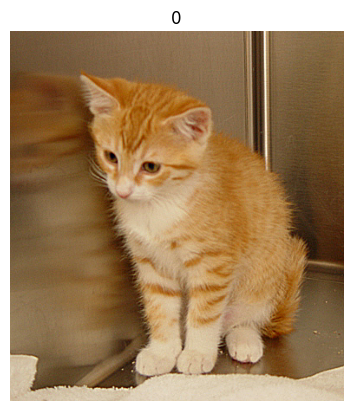

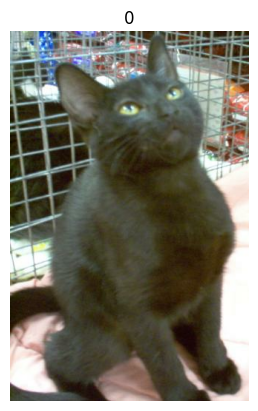

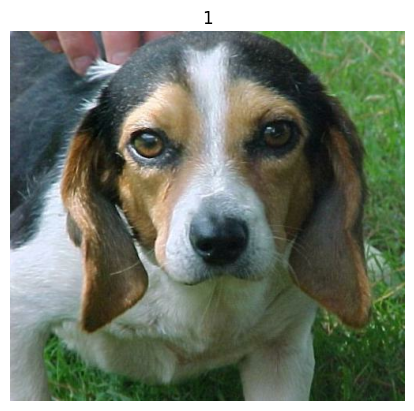

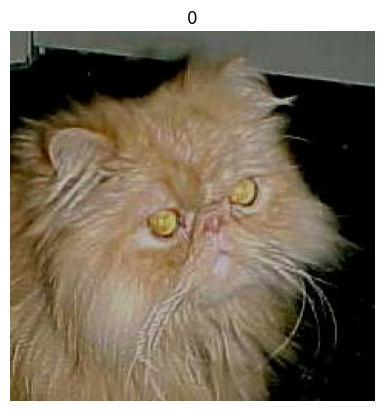

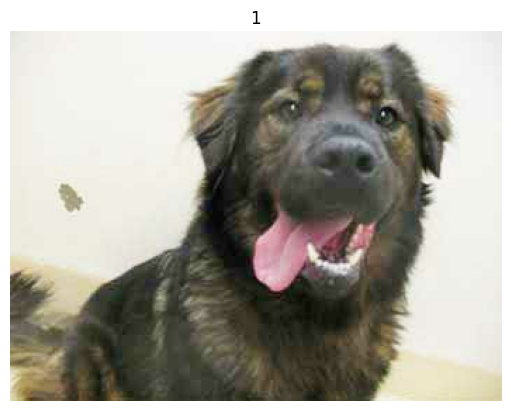

In [26]:
## Show the image and label
import matplotlib.pyplot as plt
import numpy as np

def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label)
  plt.axis('off')

for image, label in cat_dog_valid.take(5):
  show(image, label.numpy())

**exercise**

1. Are the images of equal size? What is the value range of each pixel?
2. What happens if you change the argument `as_supervised` of load() to `False`?
3. Check if the two classes are balanced in the data splits.

Last week, we saw how to use `map` function to preprocess images.

In [3]:
IMAGE_SIZE = 150
def pre_process_image(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32) ## Instead of manually scale the image, call a `tf.image` tool
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE)) # height and width
  return image, label

TRAIN_BATCH_SIZE = 20
train_batches = cat_dog_train.map(pre_process_image).batch(TRAIN_BATCH_SIZE).cache().repeat()
validation_batches = cat_dog_valid.map(pre_process_image).batch(TRAIN_BATCH_SIZE).cache().repeat()

**question** Why do we add `repeat()` at the end of the pipelines?


### Task 1.2 Build a convnet

We follow the common practice of using multiple blocks of Conv2D+MaxPooling2D layers. The number of channels was increased from 32 to 128, to form the visual features.
In the end, two dense layers were used to perform the classification based on the convolutional features.

In [8]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

def make_model():

  model = models.Sequential()

  ## Convolutional base
  model.add(layers.Conv2D(32, (3, 3), activation='relu',
                          input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  ## Dense head
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))  # for classification
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

  return model

model = make_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

2024-08-21 23:56:31.078677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


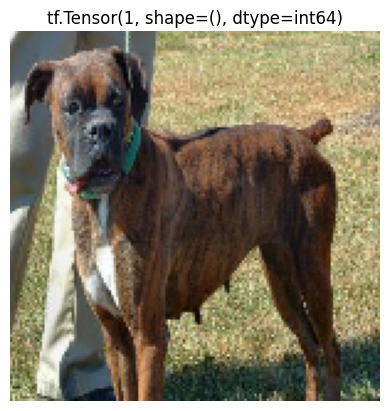

Now we can feed the input pipelines to the model's `fit` method.
As we used `repeat()` in the pipelines, we need to define what an **epoch** means. This is done through the `steps_per_epoch` argument.

In [24]:
%%time

model = make_model()

history = model.fit(
      train_batches,
      steps_per_epoch=100,
      epochs=25,
      validation_data=validation_batches,
      validation_steps=50
      )

model.save('cats_and_dogs_small_1.h5')

Epoch 1/25


/Users/xinzheli/miniconda3/envs/learn_dl/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - acc: 0.5347 - loss: 0.6934 - val_acc: 0.4900 - val_loss: 0.6924
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - acc: 0.5530 - loss: 0.6851 - val_acc: 0.5790 - val_loss: 0.6775
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - acc: 0.5958 - loss: 0.6701 - val_acc: 0.6490 - val_loss: 0.6551
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - acc: 0.6399 - loss: 0.6467 - val_acc: 0.6730 - val_loss: 0.6321
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - acc: 0.6650 - loss: 0.6180 - val_acc: 0.6820 - val_loss: 0.6142
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - acc: 0.6912 - loss: 0.5900 - val_acc: 0.6870 - val_loss: 0.6002
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - acc: 0.7089 - loss: 0.5627 - val_acc: 0.6890 - val_loss: 0.5888
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - acc: 0.7308 - loss: 0.5356 - val_acc: 0.7050 - val_loss: 0.5780
Epoch 9/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - acc:

CPU times: user 41.1 s, sys: 10.3 s, total: 51.4 s
Wall time: 1min 4s


In [18]:
######## Removed ######## 
# We will use a nicer-looking plot function to view the training curves.
# %pip install git+https://github.com/tensorflow/docs

# plotter = tfdocs.plots.HistoryPlotter()
# plotter.plot({"": history}, metric = "loss")
# plt.title("Loss")
# plt.ylim([0,1])

<Figure size 1200x500 with 0 Axes>

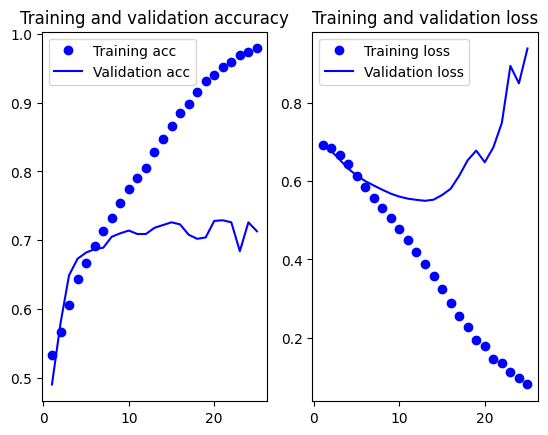

In [52]:
import matplotlib.pyplot as plt
# do not use tfdocs
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# two subplots
plt.figure(figsize=(12, 5))
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(epochs, acc, 'bo', label='Training acc')
ax1.plot(epochs, val_acc, 'b', label='Validation acc')
ax1.legend()
ax1.set_title('Training and validation accuracy')


ax2.plot(epochs, loss, 'bo', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend()
plt.show()


Overfitting is more obvious from the plot of loss functions.

Let's look at how the model performs on the test set.

In [ ]:
model.evaluate(cat_dog_test.map(pre_process_image).batch(TRAIN_BATCH_SIZE))

50/50 [==============================] - 2s 42ms/step - loss: 0.9294 - acc: 0.7610


[0.9294068217277527, 0.7609999775886536]

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


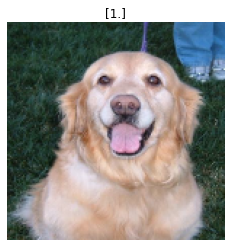

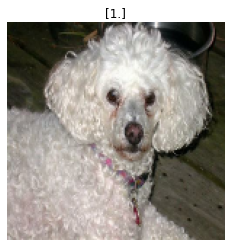

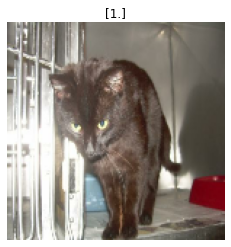

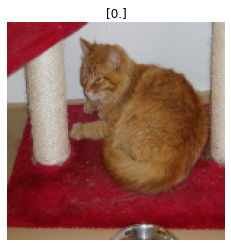

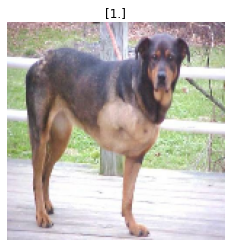

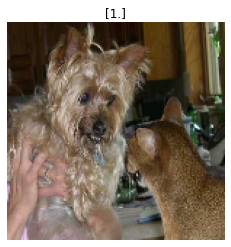

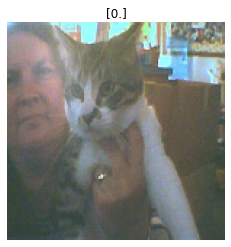

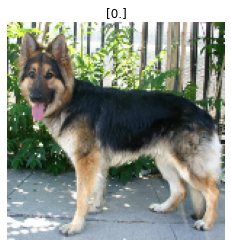

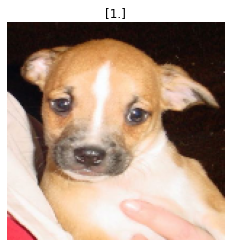

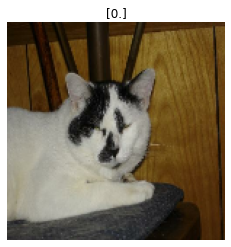

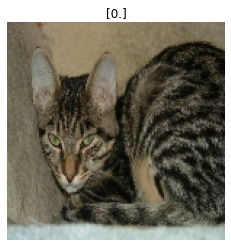

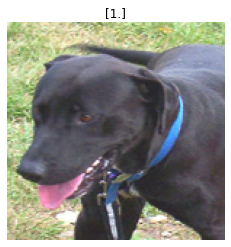

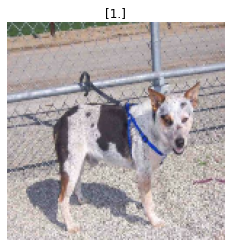

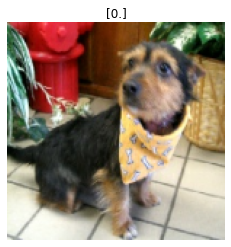

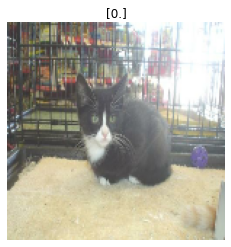

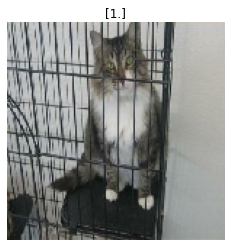

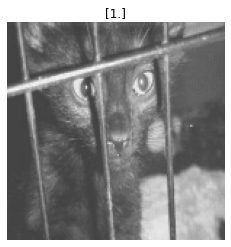

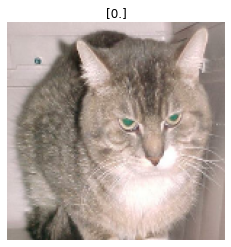

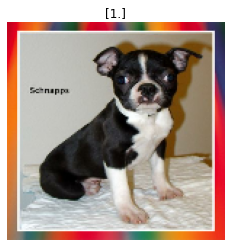

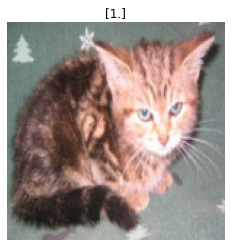

In [ ]:
for images, labels in cat_dog_test.map(pre_process_image).batch(TRAIN_BATCH_SIZE).take(1):
  predictions = model.predict(images)
  for image, prediction in zip(images, predictions):
    show(image, np.round(prediction))

**exercise** We used 3x3 convolution filters in the above example. Try increase the size of the convolution filters (particular at the first convolution layer) and see how the training and testing accuracy change. You may change the `strides` argument for larger filters.

## Task 2 Regularise the training


### Task 2.1 Using data augmentation

In Week 5, we learned that two ways to address overfitting include data augmentation and regularisation. In training convnet, data augmentation often means generating randomly transformed images from the existing training set. We can use image transformations provided in `tf.image`.

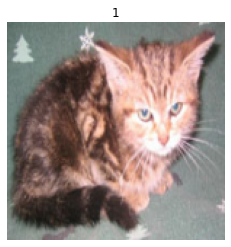

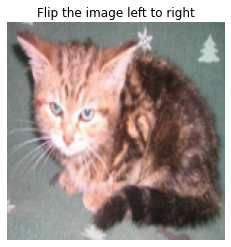

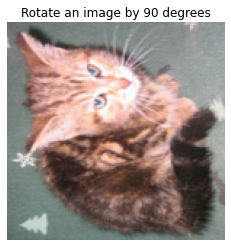

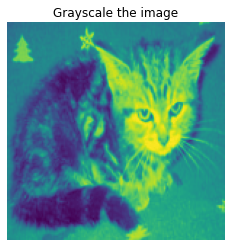

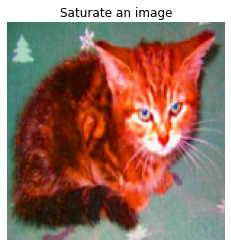

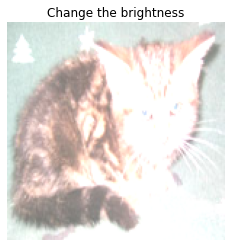

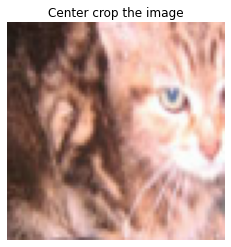

In [ ]:
for images, labels in cat_dog_train.take(1):
  show(image, label.numpy())

  show(tf.image.flip_left_right(image), label="Flip the image left to right")

  show(tf.image.rot90(image), "Rotate an image by 90 degrees")

  show(tf.squeeze(tf.image.rgb_to_grayscale(image)), "Grayscale the image")

  show(tf.image.adjust_saturation(image, 3), "Saturate an image")

  show(tf.image.adjust_brightness(image, 0.4), "Change the brightness")

  show(tf.image.central_crop(image, central_fraction=0.5), "Center crop the image")


**exercise** Follow the example above to

- flip the image upside down
- change the image with random brightness
- change the image with random contrast
- randomly crop the image


Now let's add random transformations to the input pipeline.

2024-08-21 23:44:49.597919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


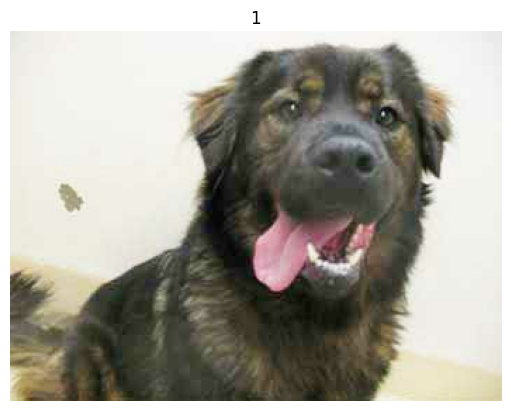

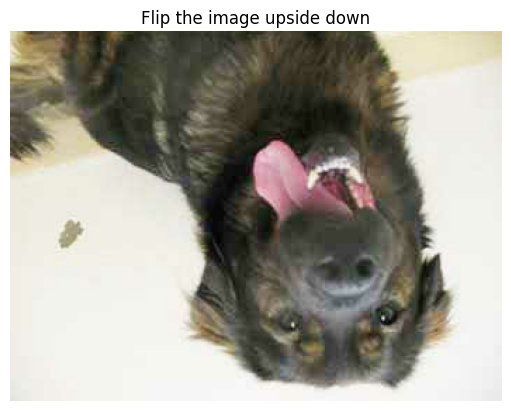

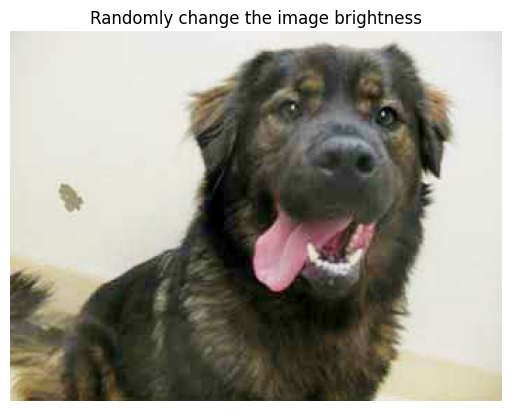

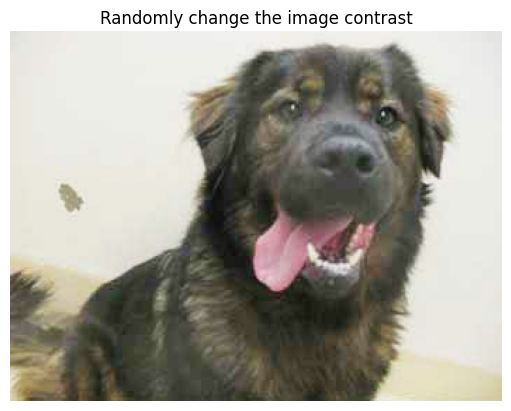

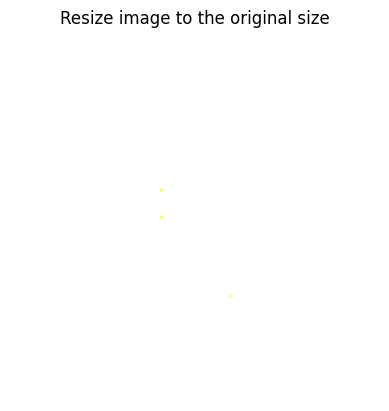

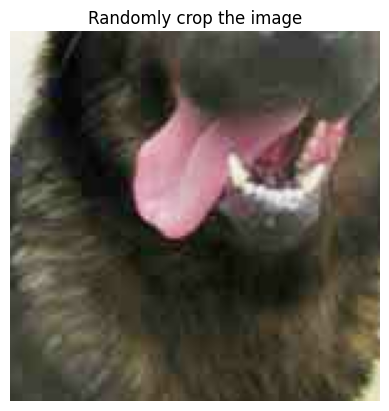

In [33]:
for images, labels in cat_dog_train.take(1):
  show(image, label.numpy())

  show(tf.image.flip_up_down(image), label="Flip the image upside down")

  show(tf.image.random_brightness(image, max_delta=0.1), "Randomly change the image brightness")

  show(tf.image.random_contrast(image, lower=0.8, upper=1.2), "Randomly change the image contrast")
  
  show(tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE]), "Resize image to the original size")

  show(tf.image.random_crop(image, size=[150, 150, 3]), "Randomly crop the image")

  



In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def augment(image,label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.random_flip_left_right(image)
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  image = tf.image.resize_with_pad(image, IMAGE_SIZE + 6, IMAGE_SIZE + 6) # Add pixels of padding
  image = tf.image.random_crop(image, size=[IMAGE_SIZE, IMAGE_SIZE, 3]) # Random crop back to IMAGE_SIZExIMAGE_SIZE
  return image, label

augmented_train_batches = (
    cat_dog_train
    .cache()
    # The augmentation is added here.
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(TRAIN_BATCH_SIZE)
    .repeat()
    .prefetch(AUTOTUNE)
)


Retrain the model with the augmented data.

In [ ]:
%%time

model = make_model()


aug_history = model.fit(
      augmented_train_batches,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_batches,
      validation_steps=100
      )

model.save('cats_and_dogs_small_augmented.h5')

Epoch 1/30
100/100 [==============================] - 8s 81ms/step - loss: 0.6902 - acc: 0.5470 - val_loss: 0.6823 - val_acc: 0.5440
Epoch 2/30
100/100 [==============================] - 4s 42ms/step - loss: 0.6688 - acc: 0.5865 - val_loss: 0.6356 - val_acc: 0.6590
Epoch 3/30
100/100 [==============================] - 4s 43ms/step - loss: 0.6362 - acc: 0.6390 - val_loss: 0.6033 - val_acc: 0.6910
Epoch 4/30
100/100 [==============================] - 4s 42ms/step - loss: 0.6058 - acc: 0.6765 - val_loss: 0.5850 - val_acc: 0.6980
Epoch 5/30
100/100 [==============================] - 4s 44ms/step - loss: 0.5881 - acc: 0.6915 - val_loss: 0.5723 - val_acc: 0.7000
Epoch 6/30
100/100 [==============================] - 4s 42ms/step - loss: 0.5705 - acc: 0.7110 - val_loss: 0.5609 - val_acc: 0.7130
Epoch 7/30
100/100 [==============================] - 4s 42ms/step - loss: 0.5569 - acc: 0.7130 - val_loss: 0.5566 - val_acc: 0.7110
Epoch 8/30
100/100 [==============================] - 4s 42ms/step - 

(0.0, 1.0)

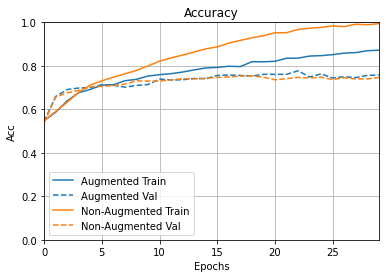

In [ ]:
# plotter = tfdocs.plots.HistoryPlotter()
# plotter.plot({ "Augmented": aug_history, "Non-Augmented": history}, metric = "acc")
# plt.title("Accuracy")
# plt.ylim([0,1])

(0.0, 1.0)

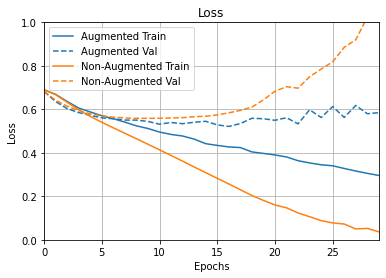

In [ ]:
# plotter = tfdocs.plots.HistoryPlotter()
# plotter.plot({ "Augmented": aug_history, "Non-Augmented": history}, metric = "loss")
# plt.title("Loss")
# plt.ylim([0,1])

As we can see, the augmented data reduced overfitting.


**exercise** Change the example above to incorporate the following types of augmentations:

- Randomly flip an image vertically (upside down)
- Randomly rotate an image
- Randomly adjust the brightness, hue, saturation, or contrast

### Task 2.2 Add dropout

In week 4, we introduced dropout as a regularisation measure. It is often applied between dense layers.

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())

model.add(layers.Dropout(0.2))

# transformers
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
            optimizer=optimizers.RMSprop(lr=1e-4),
            metrics=['acc'])

Retrain with both data augmentation and dropout.

In [ ]:
dropout_history = model.fit(
      augmented_train_batches,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_batches,
      validation_steps=100
      )

model.save('cats_and_dogs_small_augmented.h5')

In [ ]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Augmented": aug_history, "Non-Augmented": history, "Dropout": dropout_history}, metric = "acc")
plt.title("Accuracy")
plt.ylim([0,1])

In [ ]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({ "Augmented": aug_history, "Non-Augmented": history, "Dropout": dropout_history}, metric = "loss")
plt.title("Loss")
plt.ylim([0,1])

As you can see that overfitting has been further reduced.

**exercise** Try different dropout rates and see how they impact on the training and validation accuracy.

## Additional resources

- TensorFlow tutorial on [image classification](https://www.tensorflow.org/tutorials/images/classification)
- TensorFlow tutorial on [data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation)